# Baseline testing
Using persist, mean and median methods on unit wb_47 from start to end of june (approx 3 weeks)

Based on the ebook:  machine learning mastery "Deep learning time series forecasting", by Jason Brownlee

Persistent method
The forecast value is equal to some number a specified number of items previous - denoted by n. THis can be anywhere from -1 ie the previous value, to -n the first number collected. The offset value introduces seasonality to take the persist value back 24 hours.

Mean method
Takes the mean of the previous n values ranging from -1 which is simply toht eprevious value to -n which is the mean of the full history
Intorducing an offset of 24 takes a mean back every 24 hours until the dataset is exhausted.

Median method: Likewise thakes the median of hte previous n values, or if the offset is greater than 1 then the same hour 24 hours previously.

# Simple visualisation

In [64]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
# # load in data and visualise
# series = pd.read_csv('wb_47_for_arima.csv', parse_dates=True, index_col = 'time', header=0)
# # reduce to series including only pm2.5 data
# series = series.iloc[:,1]

In [66]:
# load in data and visualise
dataset = pd.read_csv('wb_47_for_arima.csv', parse_dates=True, index_col = 'time', header=0)
# Limit datast so it only includes complete 24 hour periods
dataset = dataset.iloc[9:489, 1]
dataset = dataset.values

In [67]:
# summarize shape
print(dataset.shape)

(480,)


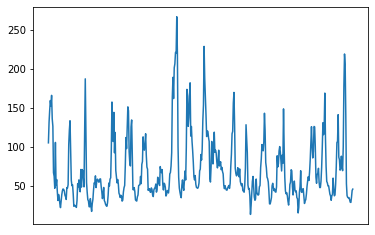

In [68]:
# plot
plt.plot(dataset)
plt.xticks([])
plt.show()

## Running Gridsearch simple forecast

In [69]:
# Importing required libraries
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import psutil

In [70]:
# one-step simple forecast
# Takes the history at that point and the configuration specified and generates a persistent, mean or median score
def simple_forecast(history, config):
    
    # unpack each config with its xxxx, offset ie 1 or 12 and the average type
    n, offset, avg_type = config
   
    # persist value, ignore other config and make the prediction equal to n places ago.
    if avg_type == 'persist':
        return history[-n]
    
    # collect values to average
    # initiate list
    values = list()
    # if the offset is 1 then take mean of the last n samples
    if offset == 1:
        values = history[-n:]
    else:
        # skip bad configs
        # if size of the offset times the number of samples is greater than history ie history is too short
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n,offset))
        # try and collect n values using offset
        # for i in the range from 1 to n+1
        for i in range(1, n+1):
            ix = i * offset
            values.append(history[-ix])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values
    if avg_type == 'mean':
        return mean(values)
    # median of last n values
    return median(values)

In [71]:
# restating mean square error function as root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [72]:
# split a univariate dataset into train/test sets using the n-test value and returns size of each
# n-test states the size of the training set
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [73]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    # create an empty list predictions
    predictions = list()
    
    # split dataset according to n_test value
    train, test = train_test_split(data, n_test)
    
    # seed history with list of all values in training dataset
    history = [x for x in train]
    # for each value / time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast based on history
        yhat = simple_forecast(history, cfg)
        print(yhat)
        # store forecast value in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error once loop is complete
    error = measure_rmse(test, predictions)
    return error

In [74]:
# score a model, return None on failure

def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [75]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=psutil.cpu_count(), verbose=1)
        #         executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')

        tasks = (delayed(score_model)(data, n_test, cfg, debug=False) for cfg in cfg_list)
#         tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg, debug=False) for cfg in cfg_list]
    # remove empty results
#     print(scores)
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [76]:
# create a set of simple configs to try
# Simple loop that runs through each item in the training set (max_length), each specified offset and each of three models
# prints the configuration and finally adds the configuration to a list.
def simple_configs(max_length, offsets=[168]):

    configs = list()
    for i in range(1, max_length+1):
#         print(i)
        for o in offsets:
#             print(o)
            for t in ['persist', 'mean', 'median']:
#                 print(t)
                cfg = [i, o, t]
                print(cfg)
                configs.append(cfg)
#     print(configs)     
    return configs

## Finally the script to run the model

In [77]:
## Define dataset ##

# read csv 
# load in data and visualise
series = pd.read_csv('wb_47_for_arima.csv', parse_dates=True, index_col = 'time', header=0)
# series = read_csv('wb_47_for_arima.csv', header=0, index=0)
series = series.iloc[:,1]
# limit dataset to values only and save as an array
data = series.values
# limit to first 60 values ie 5 years
# data = data[:60]
# set counter
count=0
# set value for train test split
n_test = 168
# model configs - set max length for training set
max_length = len(data) - n_test
print(max_length)
# data

335


In [78]:
# Creating a list of configurations to try using the simple configs function
# This takes each element of the training set combined with offsets of 1 and 12 and each of three approaches
cfg_list = simple_configs(max_length, offsets=[168])

[1, 168, 'persist']
[1, 168, 'mean']
[1, 168, 'median']
[2, 168, 'persist']
[2, 168, 'mean']
[2, 168, 'median']
[3, 168, 'persist']
[3, 168, 'mean']
[3, 168, 'median']
[4, 168, 'persist']
[4, 168, 'mean']
[4, 168, 'median']
[5, 168, 'persist']
[5, 168, 'mean']
[5, 168, 'median']
[6, 168, 'persist']
[6, 168, 'mean']
[6, 168, 'median']
[7, 168, 'persist']
[7, 168, 'mean']
[7, 168, 'median']
[8, 168, 'persist']
[8, 168, 'mean']
[8, 168, 'median']
[9, 168, 'persist']
[9, 168, 'mean']
[9, 168, 'median']
[10, 168, 'persist']
[10, 168, 'mean']
[10, 168, 'median']
[11, 168, 'persist']
[11, 168, 'mean']
[11, 168, 'median']
[12, 168, 'persist']
[12, 168, 'mean']
[12, 168, 'median']
[13, 168, 'persist']
[13, 168, 'mean']
[13, 168, 'median']
[14, 168, 'persist']
[14, 168, 'mean']
[14, 168, 'median']
[15, 168, 'persist']
[15, 168, 'mean']
[15, 168, 'median']
[16, 168, 'persist']
[16, 168, 'mean']
[16, 168, 'median']
[17, 168, 'persist']
[17, 168, 'mean']
[17, 168, 'median']
[18, 168, 'persist']
[18

[158, 168, 'persist']
[158, 168, 'mean']
[158, 168, 'median']
[159, 168, 'persist']
[159, 168, 'mean']
[159, 168, 'median']
[160, 168, 'persist']
[160, 168, 'mean']
[160, 168, 'median']
[161, 168, 'persist']
[161, 168, 'mean']
[161, 168, 'median']
[162, 168, 'persist']
[162, 168, 'mean']
[162, 168, 'median']
[163, 168, 'persist']
[163, 168, 'mean']
[163, 168, 'median']
[164, 168, 'persist']
[164, 168, 'mean']
[164, 168, 'median']
[165, 168, 'persist']
[165, 168, 'mean']
[165, 168, 'median']
[166, 168, 'persist']
[166, 168, 'mean']
[166, 168, 'median']
[167, 168, 'persist']
[167, 168, 'mean']
[167, 168, 'median']
[168, 168, 'persist']
[168, 168, 'mean']
[168, 168, 'median']
[169, 168, 'persist']
[169, 168, 'mean']
[169, 168, 'median']
[170, 168, 'persist']
[170, 168, 'mean']
[170, 168, 'median']
[171, 168, 'persist']
[171, 168, 'mean']
[171, 168, 'median']
[172, 168, 'persist']
[172, 168, 'mean']
[172, 168, 'median']
[173, 168, 'persist']
[173, 168, 'mean']
[173, 168, 'median']
[174, 16

In [80]:
# run the grid search using full set of data, the above configuration list and the train/test split
scores = grid_search(data, cfg_list, n_test)
print('done')
# Print top 3 configs along with their error score
for cfg, error in scores[:100]:
    print(cfg, error)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


done
[1, 168, 'persist'] 22.94160113772256
[2, 168, 'persist'] 35.79946724972087
[3, 168, 'persist'] 44.72014943936624
[265, 168, 'persist'] 45.6202522327873
[288, 168, 'persist'] 46.09819031381526
[287, 168, 'persist'] 46.61730357553235
[289, 168, 'persist'] 46.70147989716325
[264, 168, 'persist'] 47.60047299378163
[266, 168, 'persist'] 47.899219346223006
[286, 168, 'persist'] 48.31571113492611
[290, 168, 'persist'] 49.57597671277293
[335, 168, 'persist'] 50.44753119988049
[49, 168, 'persist'] 50.490241119461054
[285, 168, 'persist'] 50.55422957514342
[263, 168, 'persist'] 50.787982797254855
[50, 168, 'persist'] 50.80253965406905
[4, 168, 'persist'] 50.94910098784435
[72, 168, 'persist'] 51.333895717646755
[71, 168, 'persist'] 51.51374032740208
[51, 168, 'persist'] 51.57390162529102
[334, 168, 'persist'] 51.67035744690384
[48, 168, 'persist'] 51.97288864140236
[284, 168, 'persist'] 52.01115894037595
[73, 168, 'persist'] 52.03771813562725
[239, 168, 'persist'] 52.097224650639916
[267, 

[Parallel(n_jobs=8)]: Done 1005 out of 1005 | elapsed:    1.4s finished
